# Notebook for generating analysis and panels in Figure 4

In [1]:
%pylab
%matplotlib inline
%reload_ext autoreload
if sys.platform != 'darwin':
    os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-3.6.0" # change as needed
%load_ext rpy2.ipython

import pandas as pd
import sys
#import seaborn as sns
sys.path.append('../../src')
import abrTools as at
import os
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
from collections import Counter
import pretty_confusion_matrix as pcm
from scipy.signal import savgol_filter


fs = 195000.0/2.0 # Acquisition sampling rate

from datetime import date
savefolder = os.path.join('..','results',str(date.today()))


from matplotlib.pyplot import errorbar
rcParams["font.family"] = "Arial"
rcParams['axes.linewidth'] = 5
rcParams["xtick.major.size"] = 20
rcParams["xtick.major.width"] = 5
rcParams["xtick.major.pad"] = 10

rcParams["ytick.major.size"] = 20
rcParams["ytick.major.width"] = 5
rcParams["xtick.minor.size"] = 10
rcParams["xtick.minor.width"] = 5

rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
markersize=35*1.3
fontSize = 54*1.3
import matplotlib.gridspec as gridspec
import figureTools as ft
resultFolder = '../../results/2024-11-20'

Using matplotlib backend: <object object at 0x1171be450>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
data,thresholds,dataversion = at.loadFiles(datafolder='../../data')
abr6N = []
abrRep = []
folderN = 1
for i,el in data.iterrows():
    strain = el['Strain']
    if not pd.isna(el[f'Folder {folderN}']):
        folder = os.path.join('../../data',el[f'Folder {folderN}'][2:])
        abr = at.extractABR(folder)
        if strain =='6N':
            abr6N.append(abr)
        elif strain =='Repaired':
            abrRep.append(abr)

abr = pd.concat(abr6N+abrRep).reset_index().groupby(['level_0','level_1']).mean()

The dataset version is: None


Calculate and plot the Rel Mean Absolute Shapley values for two models. 

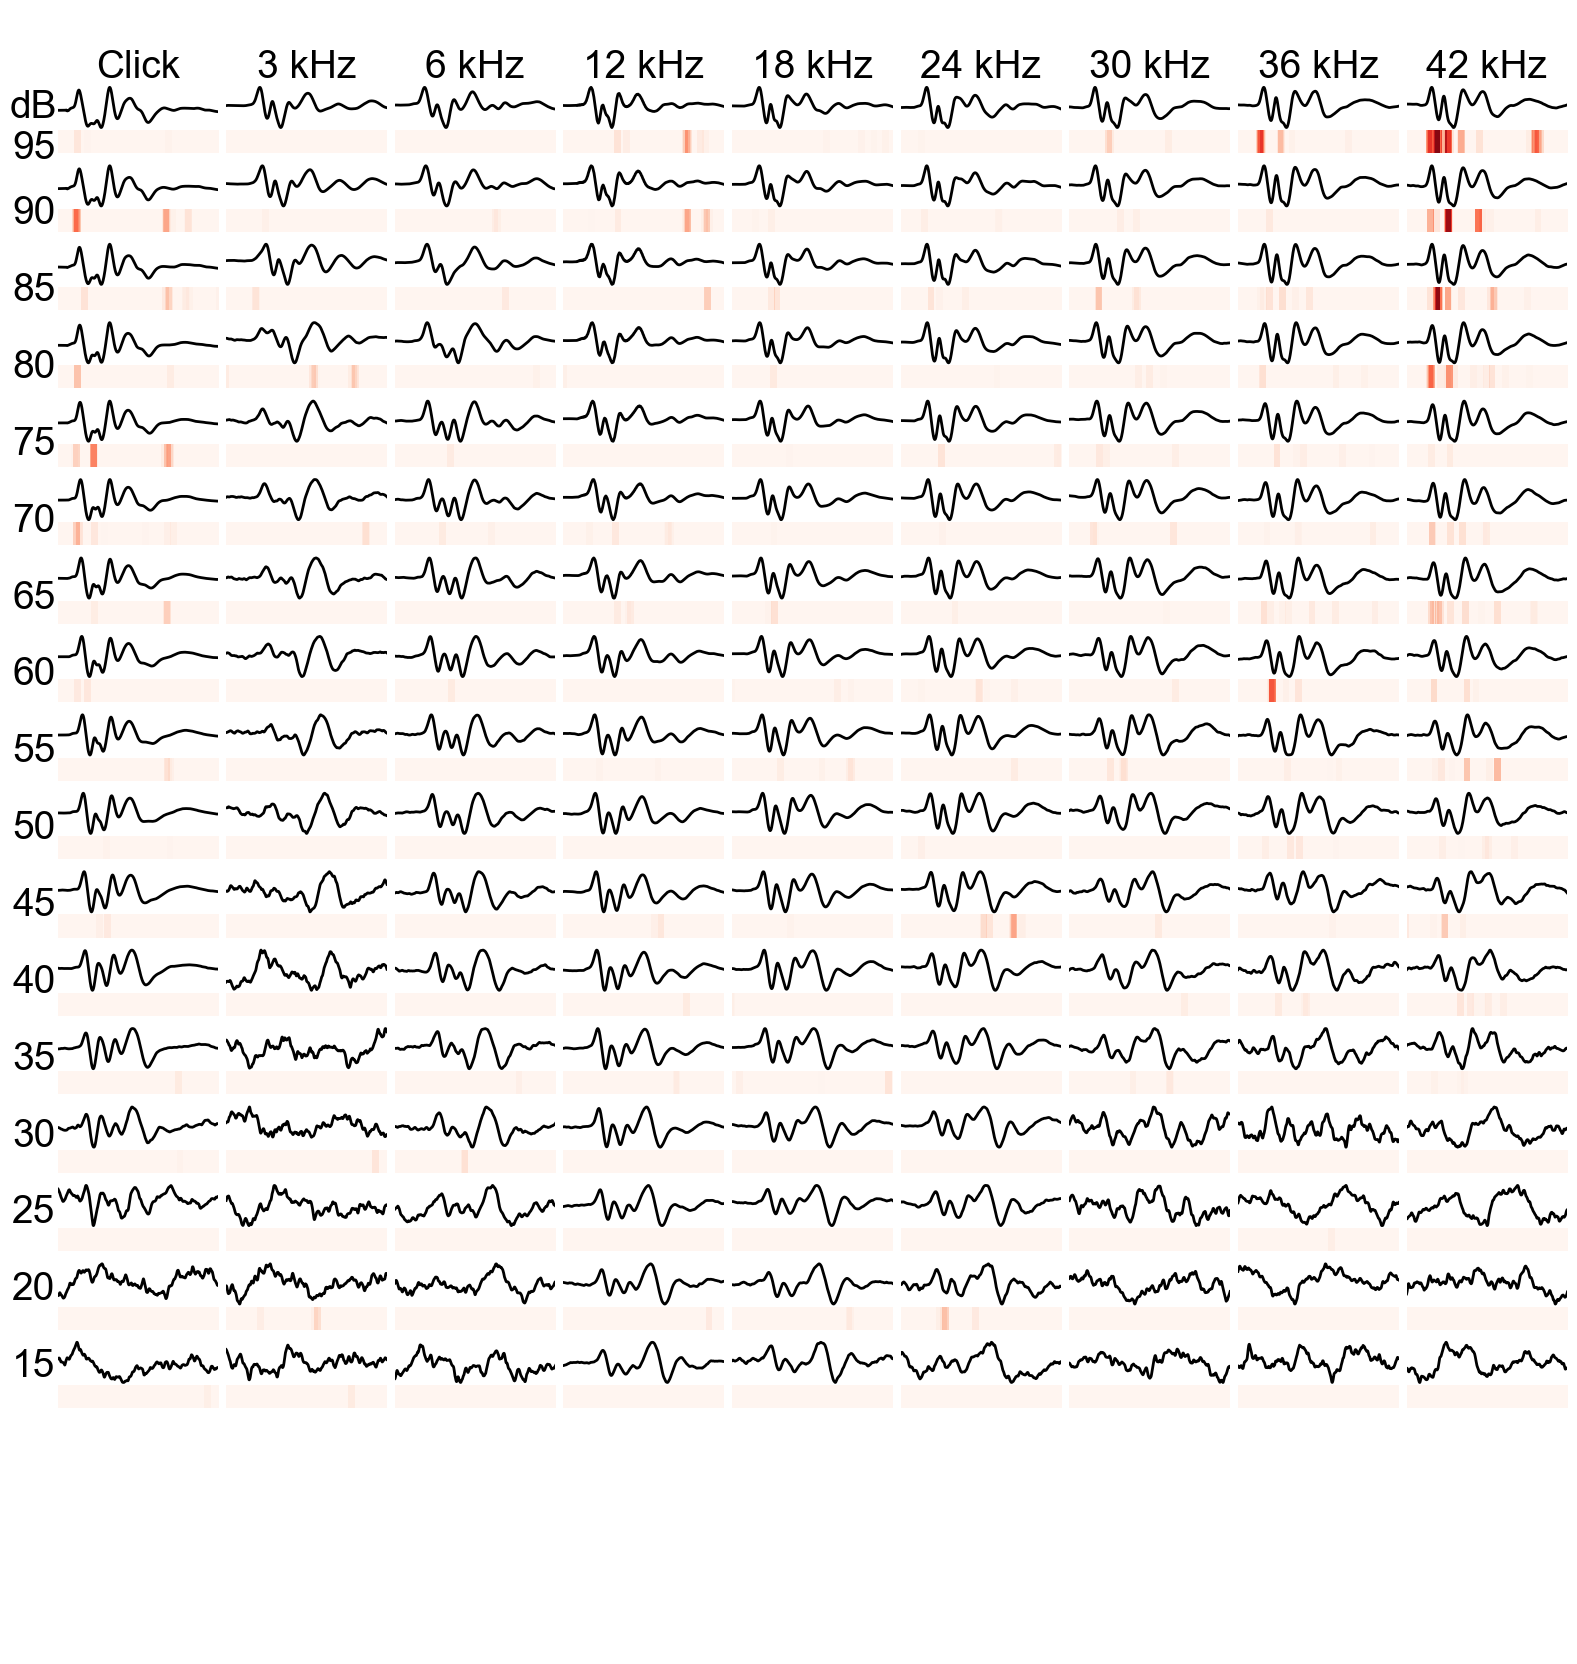

In [3]:
#Random forest 10%Anova Global

savgolFilterOrder = 41
cmap = cm.Reds

fi = pd.read_csv(os.path.join(resultFolder,'forest_kFoldCrossValidation_AnovaFS10percentGlobalShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)
#XGBOOST forest 10%Anova Global
fixgb = pd.read_csv(os.path.join(resultFolder,'XGBOOST_kFoldCrossValidation_AnovaFS10percent_GlobalShapCoeff.csv'),index_col=0)
fixgb = abs(fixgb).mean(1).values
fixgb = savgol_filter(fixgb,savgolFilterOrder,1)

fi = (fi/fi.max()+fixgb/fixgb.max())/2
fig,axs = ft.makeFigureFeatureImportance(abr.reset_index().values[:,0],abr.reset_index().values[:,1],abr.values,fi,title=' ',linecolor='k',cmap=cmap)
fig.savefig('./Panels/forest+xgboost_shapley_Global.pdf',dpi=1200,transparent=True)


Colorbar

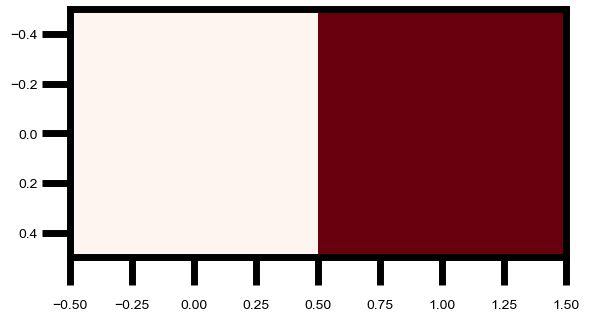

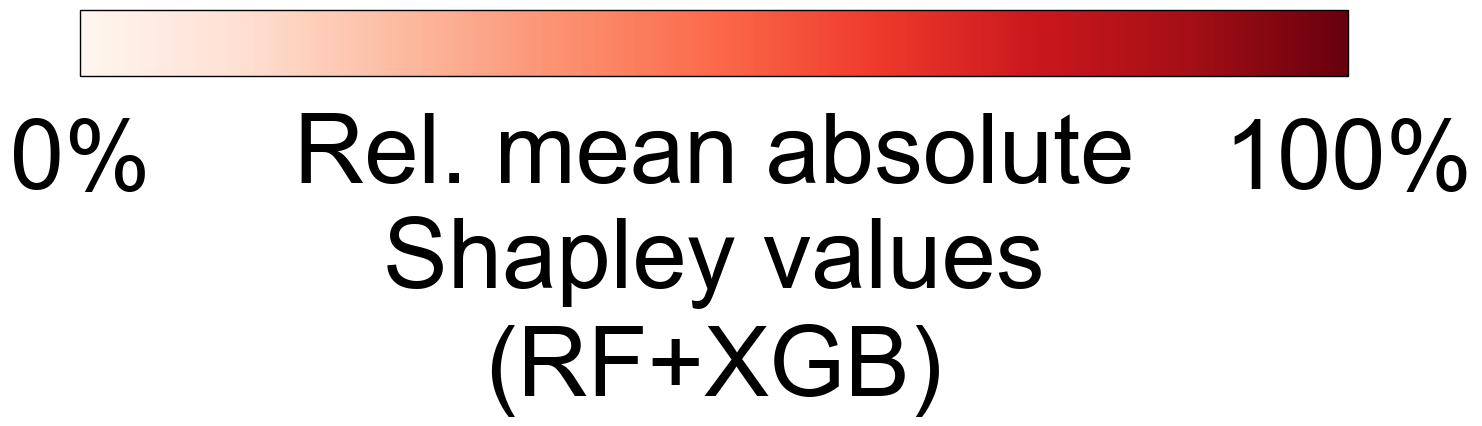

In [4]:
a = np.array([[0,1]])


img = imshow(a, cmap=cmap)
f=figure(figsize=(3.7*2.5*1.6138,3.7*2.5*1.2))
gs= gridspec.GridSpec(2,1,height_ratios=[10,1],hspace=0,figure=f)
#ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])



colorbar(orientation="horizontal", cax=ax2,mappable=img)
ax2.set_xticks([0,1],['0%','100%'])
ax2.set_xlabel('\nRel. mean absolute\nShapley values\n(RF+XGB)',rotation=0, va='center')

for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
            ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(fontSize)
ax2.xaxis.set_tick_params(width=0)
[i.set_linewidth(1) for i in ax2.spines.values()]

gs.tight_layout(f)
f.savefig('./Panels/shapleyColorbar.pdf',dpi=1200,transparent=True)